In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi, _ = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): 
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #edges追加
    ax = make_ax()
    draw_trajectory(xs, ax)
    draw_observations(xs, zlist, ax)
 #   draw_edges(edges, ax)
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）
    delta = 0.0 #追加
    us = {} #追加

    with open("log_ref.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
            elif tmp[0] == "delta":   #以下の読み込みを追加
                delta = float(tmp[1])
            elif tmp[0] == "u":
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T 
                
        return hat_xs, zlist, us, delta

In [4]:
class Edge: 
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): #sensor_noise_rate追加
        assert z1[0] == z2[0] #ランドマークのIDが違ったら処理を止める
            
        self.landmark_id = z1[0]
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.x1, self.x2 = xs[t1], xs[t2]    #各時刻の姿勢
        self.z1, self.z2 = z1[1], z2[1]     #各時刻のセンサ値
        
        ##精度行列の作成##
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        B1 = - np.array([[1, 0, -self.z1[0]*s1], #追加
                                    [0, 1, self.z1[0]*c1],
                                    [0, 0,                       1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2], #追加
                                   [0, 1,   self.z2[0]*c2],
                                    [0, 0,                        1]])
        
        self.Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        self.Omega = np.linalg.inv(self.Sigma)
        
        ##現状の誤差を計算##
        delta_psi = self.z2[2] - self.z1[2]
        delta_theta = self.x2[2] - self.x1[2]
        while delta_psi > math.pi: delta_psi -= 2*math.pi
        while delta_psi < -math.pi: delta_psi += 2*math.pi
        while delta_theta > math.pi: delta_theta-= 2*math.pi
        while delta_theta < -math.pi: delta_theta += 2*math.pi
            
        hat_e = np.array([
            self.x2[0] - self.x1[0] + self.z2[0]*c2 - self.z1[0]*c1, 
            self.x2[1] - self.x1[1] + self.z2[0]*s2 - self.z1[0]*s1,
            delta_theta - self.z1[1] + self.z2[1] - delta_psi
        ])
        
        ##情報行列に足す各部分を計算##
        self.omega_upperleft = B1.T.dot(self.Omega).dot(B1)
        self.omega_upperright = B1.T.dot(self.Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(self.Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(self.Omega).dot(B2)
        
        ##係数ベクトルに足す各部分を計算##
        self.xi_upper = - B1.T.dot(self.Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(self.Omega).dot(hat_e)
        
    def __str__(self): #Omega追加
        return "landmark:{}, x1:{}, x2:{}, z1:{}, z2:{}, \nΣ:{}".format(self.landmark_id, self.x1, self.x2, self.z1, self.z2, self.Sigma) 

In [5]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録 

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [Edge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

In [6]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

In [7]:
class XEdge: 
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]    #各時刻の姿勢
        
        v = motion_noise_stds
        nu, omega = us[t2]
        M = np.diag([v["nn"]**2*abs(nu)/delta + v["no"]**2*abs(omega)/delta, 
                     v["on"]**2*abs(nu)/delta + v["oo"]**2*abs(omega)/delta])
        
        t = self.hat_x1[2]
        st, ct = math.sin(t), math.cos(t)
        stw, ctw = math.sin(t + omega*delta), math.cos(t + omega*delta)
        A = -np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*delta*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*delta*stw],
                                 [0,                                delta]] )
        
        F = np.diag([1.0, 1.0, 1.0])
        F[0, 2] = nu / omega * (math.cos(t + omega * delta) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * delta) - math.sin(t))
        
        self.Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3)*0.0001)
        
        self.omega_upperleft = F.T.dot(self.Omega).dot(F)
        self.omega_upperright = -F.T.dot(self.Omega)
        self.omega_bottomleft = - self.Omega.dot(F)
        self.omega_bottomright = self.Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.dot(self.Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = - self.Omega.dot(self.hat_x2 - x2)
        
    def __str__(self): #Omega追加
        return "x1:{}, x2:{}\n".format(self.hat_x1, self.hat_x2) 

In [8]:
def make_x_edges(hat_xs, us, delta):
    edges = []
    for i in range(len(hat_xs)-1):
        edges.append(XEdge(i, i+1, hat_xs, us, delta))
        
    return edges

<IPython.core.display.Javascript object>


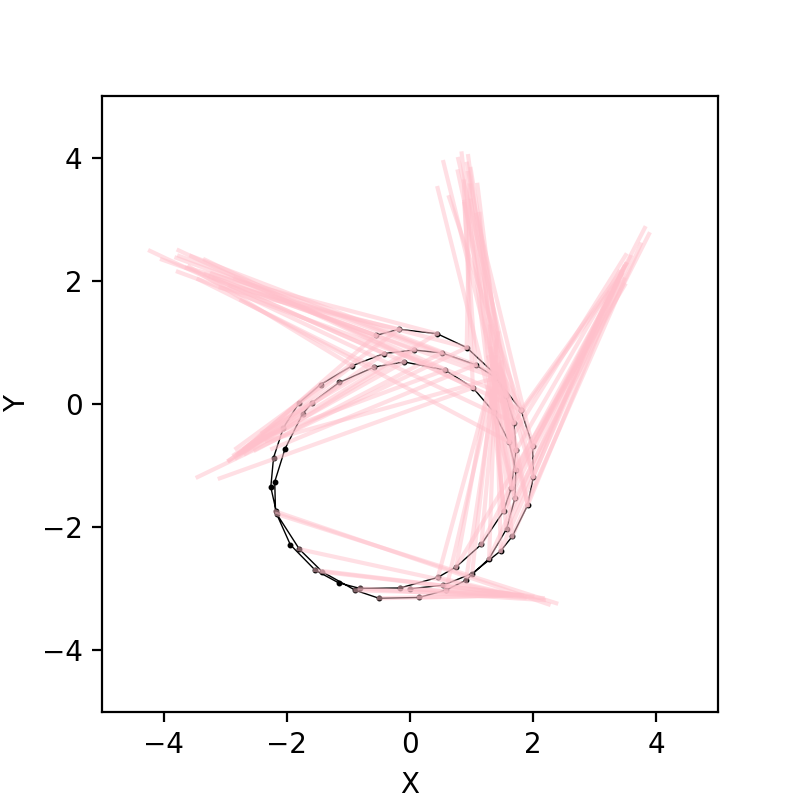

In [9]:
hat_xs, zlist, us, delta = read_data() ###graphbasedslam5draw

for j in range(1):
    edges = make_edges(hat_xs, zlist)
    xedges = make_x_edges(hat_xs, us, delta)

    dim = len(hat_xs)*3
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)

    Omega[0:3, 0:3] += np.eye(3)*1000000

    for e in edges:
        add_edge(e, Omega, xi)
    
    for e in xedges:
        add_edge(e, Omega, xi)

    delta_xs = np.linalg.inv(Omega).dot(xi)
    for i in range(len(hat_xs)):
        a = hat_xs[i]
        a[0] += delta_xs[i*3]
        a[1] += delta_xs[i*3+1]
        a[2] += delta_xs[i*3+2]

draw(hat_xs, zlist, edges)